# Camera Calibration

In this project, you will learn how to use existing OpenCV functions to perform camera calibration. The project will also help you become familiar with Python programming and working in Google Colab.

In Google Colab, similar to Jupyter Notebooks, you can easily add and rearrange text and code cells. Feel free to use text cells to write your descriptions and observations.

Note: the contents are adapted from this Google Colab https://colab.research.google.com/github/YoniChechik/AI_is_Math/blob/master/c_07_camera_calibration/multi_plane_calib.ipynb.


## Step 0: Load Data

Use the following codes to mount your Google Drive in Colab and read files from it, therefore you have flexibility to load your customized data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's check whether we can read our data by checking the number of images (of course, you can also print out all the paths to the images). In the following cells, we will first import all the Python libraries needed for this project. Note that `cv2` refers to OpenCV. If you do not understand all of these libraries yet, that is completely fine. Python allows us to reuse powerful existing tools so we can focus on the core concepts rather than low-level implementation.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm

In [3]:
# use glob library to find all image files we have stored in a specific folder
img_paths = sorted(glob.glob("/content/drive/MyDrive/Teaching/Computer_Vision/Sample_Data/Camera_Calibration/*.jpeg"))
num_imgs = len(img_paths)
print(f"found {num_imgs} images")

found 12 images


## Step 1: Find All Corners in Calibration Plane

12it [00:01,  6.39it/s]


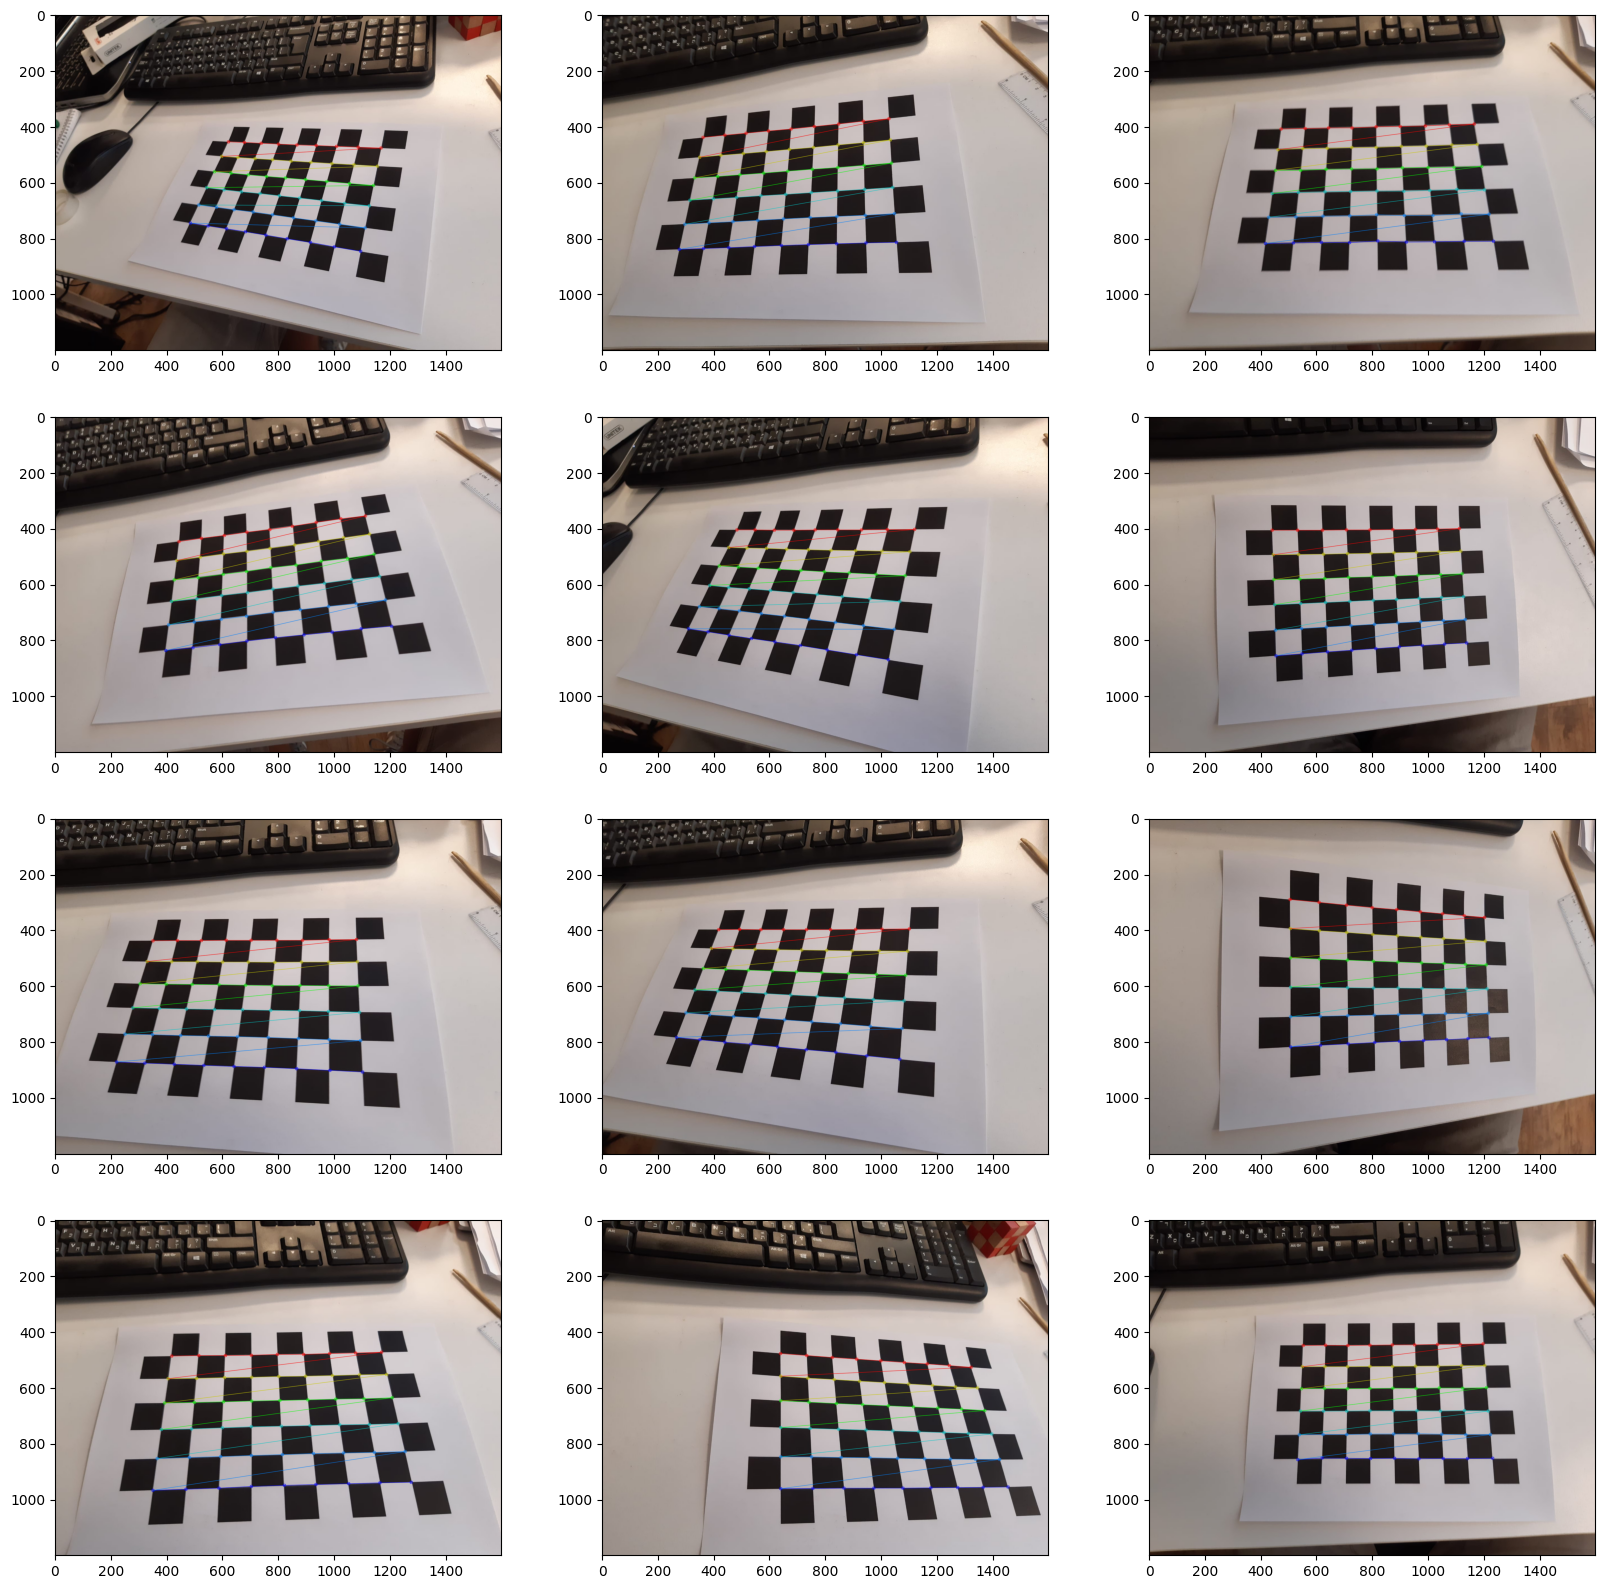

In [4]:
# compute the 3D coordinates of the calibration pattern points in the real world
pattern_size = (9, 6) # number of inner corners per a chessboard row and column
square_size = 2.88 # physical size of one square edge on the chessboard
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32) # shape: (9x6, 3) all zeros
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2) # assign X, Y values in the grid but keep Z zero (because we assume all points lie on a flat plane)
pattern_points *= square_size # scale to real-world coordinates
obj_points = []
img_points = []
h, w = cv2.imread(img_paths[0]).shape[:2]

# detect the corners and visualize the results using matplotlib
plt.figure(figsize=(20, 20))
for i, img_path in tqdm(enumerate(img_paths)):
  imgBGR = cv2.imread(img_path)
  if imgBGR is None:
        print("Failed to load", img_path)
        continue

  imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
  img = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)
  assert w == img.shape[1] and h == img.shape[0], f"wrong image size: {img.shape[1]} x {img.shape[0]}"

  found, corners = cv2.findChessboardCorners(img, pattern_size)
  if not found:
    print(f"for {img_path}, chessboard not found")

  # show the image with detected corners (plot the first 12 images for 4 rows and 3 columns)
  if i < 12:
    img_w_corners = cv2.drawChessboardCorners(imgRGB, pattern_size, corners, found)
    plt.subplot(4, 3, i + 1)
    plt.imshow(img_w_corners)

  img_points.append(corners.reshape(-1, 2))
  obj_points.append(pattern_points)

plt.show()

## Step 2: Get Camera Intrinsics and Distortion Coefficients

lso get extrinsic rotation and translation vectors per image. Rotation vector is another representation for a full R matrix
more on it here: https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula


In [5]:
# calculate camera distortion
rms, camera_matrix, dist_coefs, _rvecs, _tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

print("reprojection error:", rms)
print("3x3 intrinsic camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())

reprojection error: 0.8677792456806606
3x3 intrinsic camera matrix:
 [[1.23591636e+03 0.00000000e+00 7.87239512e+02]
 [0.00000000e+00 1.23700315e+03 6.16815195e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients:  [ 2.11482396e-01 -8.24461891e-01  2.58584437e-04  4.49649789e-04
  9.68898112e-01]


## Step 3: Application 1 -- Get Undistorted Images

12it [00:01,  7.05it/s]


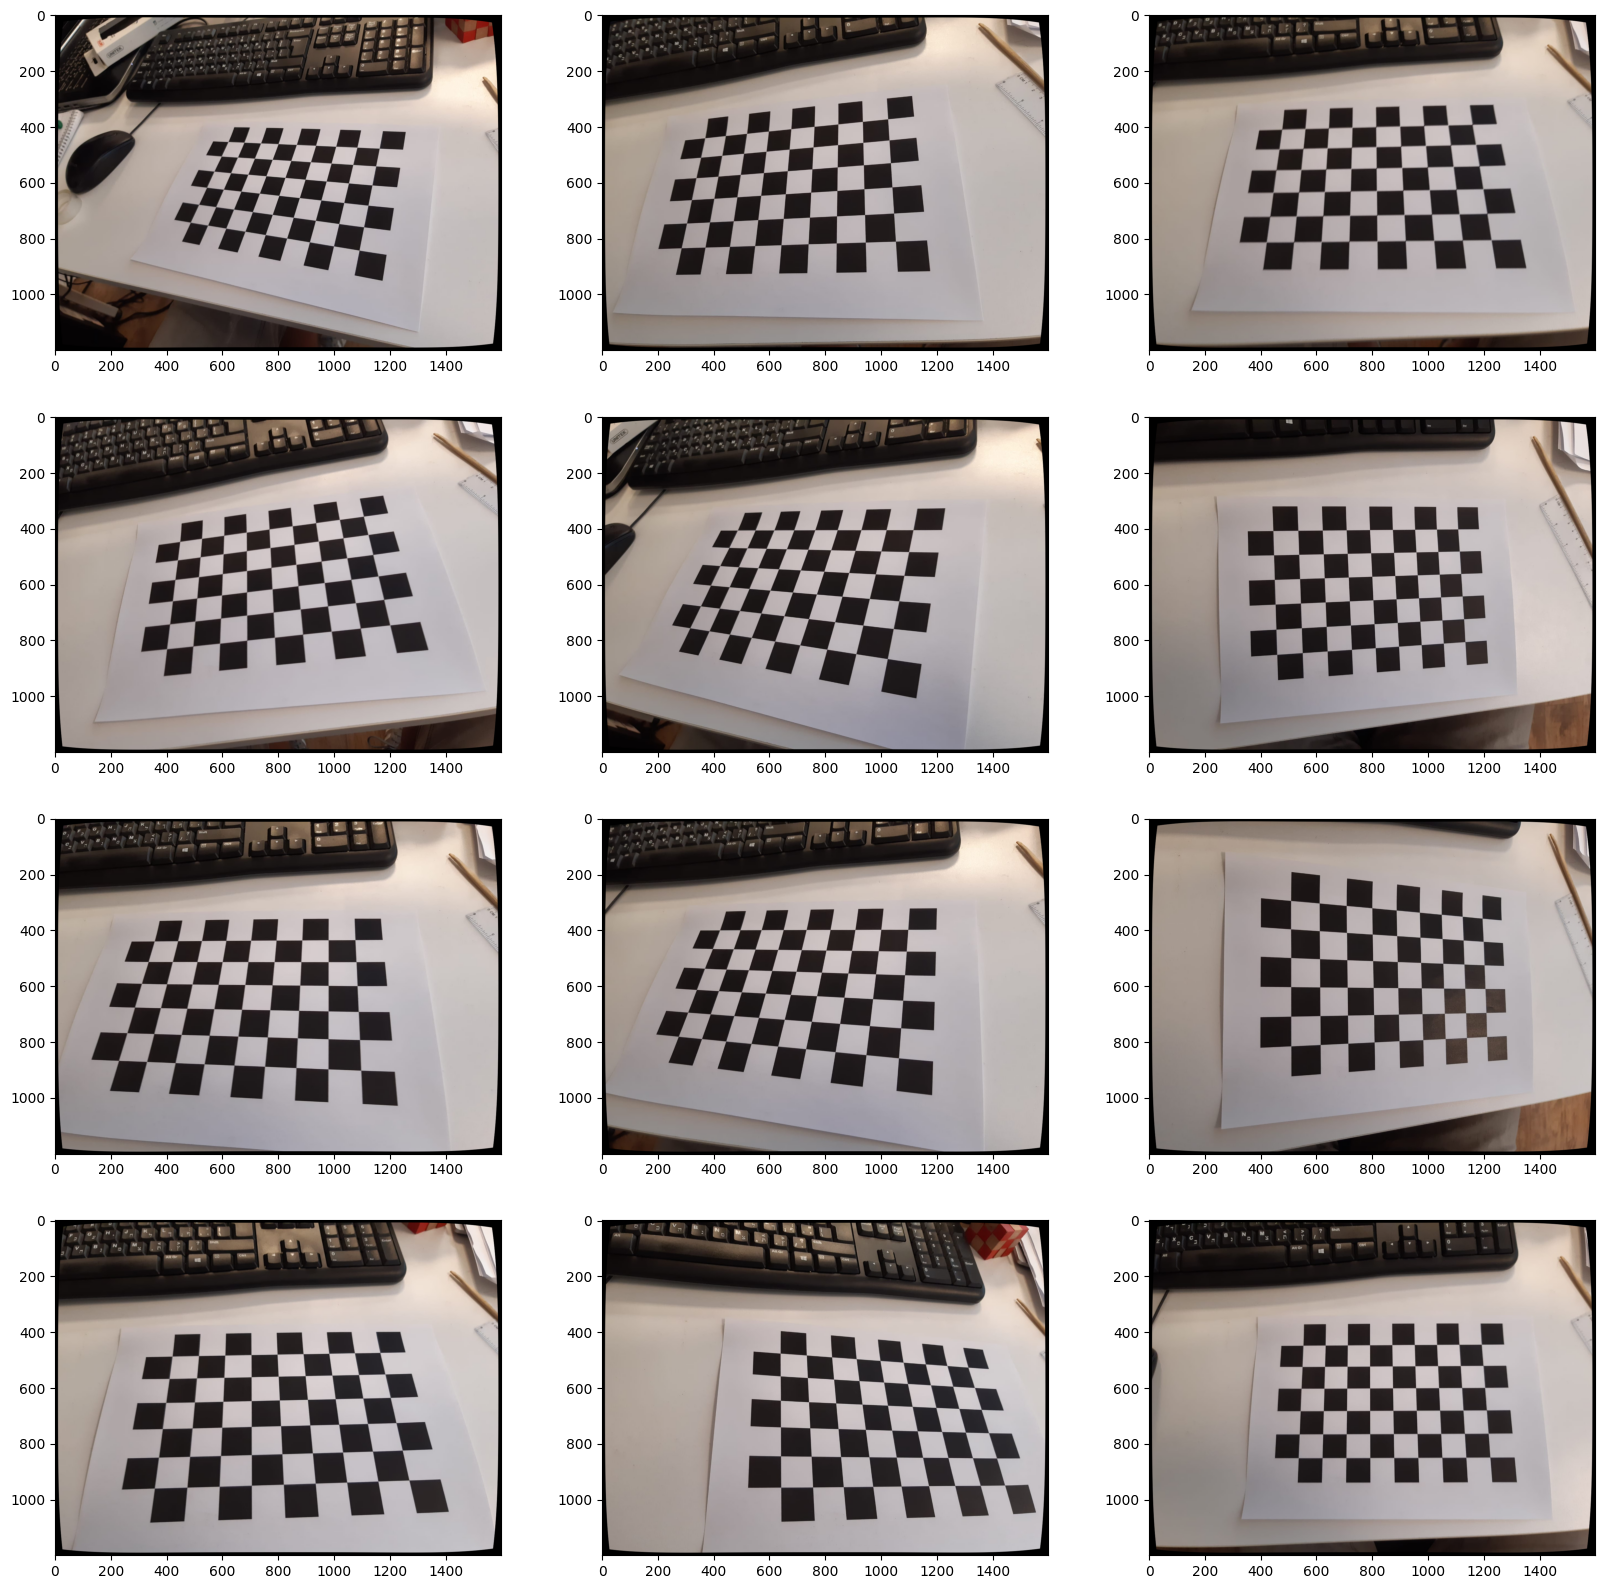

In [6]:
# undistort the image with the calibration
plt.figure(figsize=(20,20))
for i, fn in tqdm(enumerate(img_paths)):
    imgBGR = cv2.imread(fn)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    dst = cv2.undistort(imgRGB, camera_matrix, dist_coefs)
    if i < 12:
      plt.subplot(4, 3, i + 1)
      plt.imshow(dst)
plt.show()

# Step 4: Application 2 -- Project a Cube

12it [00:00, 22.55it/s]


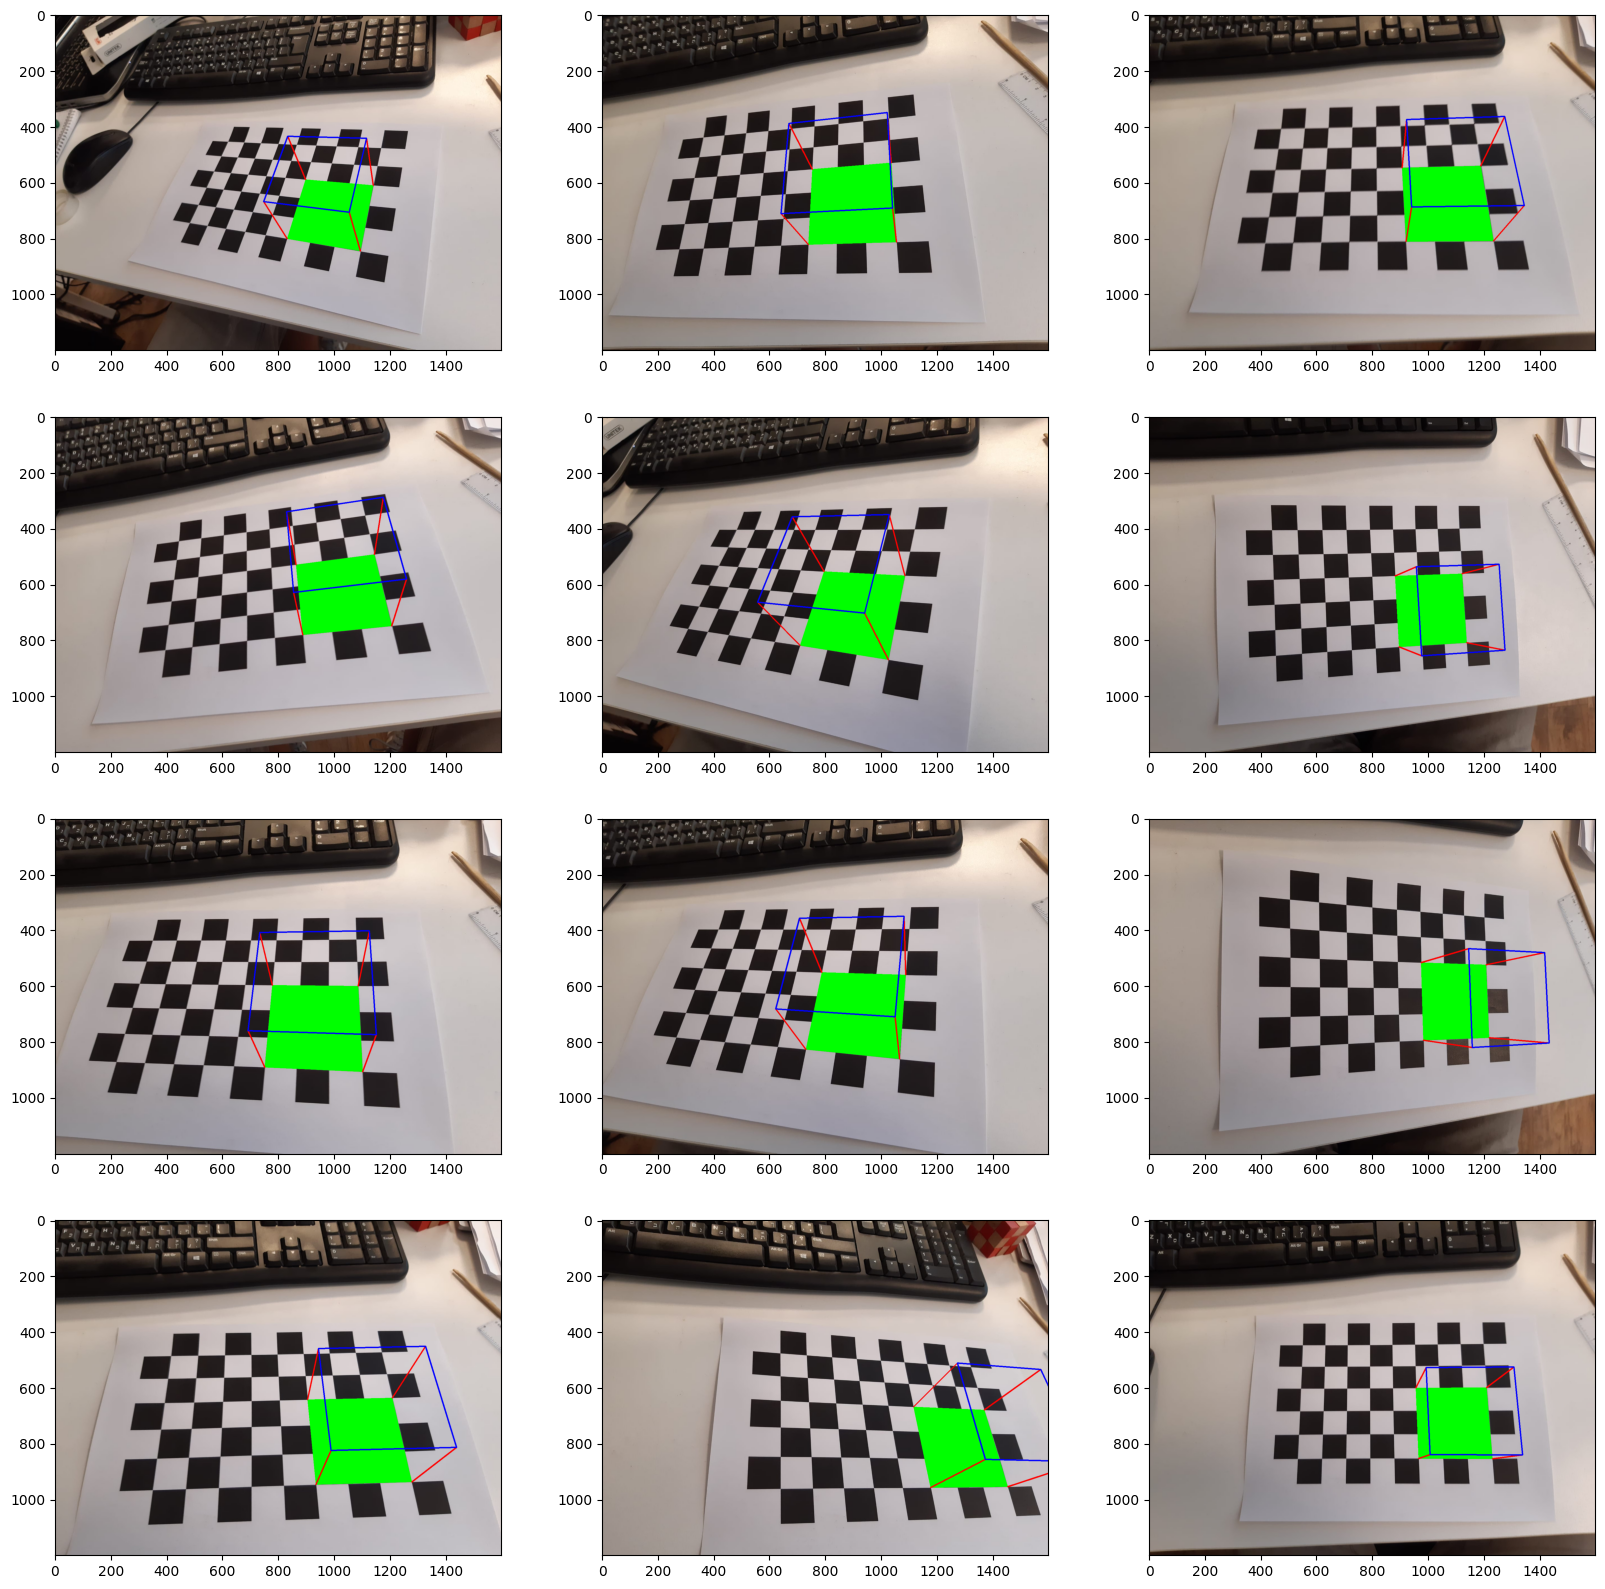

In [7]:
objectPoints = (
    3
    * square_size
    * np.array(
        [
            [0, 0, 0],
            [0, 1, 0],
            [1, 1, 0],
            [1, 0, 0],
            [0, 0, -1],
            [0, 1, -1],
            [1, 1, -1],
            [1, 0, -1],
        ]
    )
)


def draw(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]], -1, (0, 255, 0), -1)

    # draw pillars in blue color
    for i, j in zip(range(4), range(4, 8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255), 3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]], -1, (0, 0, 255), 3)

    return img


plt.figure(figsize=(20,20))
for i, fn in tqdm(enumerate(img_paths)):
    imgBGR = cv2.imread(fn)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

    imgpts = cv2.projectPoints(objectPoints, _rvecs[i], _tvecs[i], camera_matrix, dist_coefs)[0]
    drawn_image = draw(imgRGB, imgpts)

    if i < 12:
        plt.subplot(4, 3, i + 1)
        plt.imshow(drawn_image)

plt.show()